In [104]:
import gtda 
import numpy as np
from generate_data import *
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.homology import WeakAlphaPersistence
from gtda.diagrams import PersistenceEntropy
import matplotlib.pyplot as plt
from gtda.plotting import plot_diagram
from sklearn.ensemble import RandomForestClassifier
from openml.datasets.functions import get_dataset
from gtda.diagrams import Amplitude, NumberOfPoints
from sklearn.pipeline import make_union
from gtda.pipeline import Pipeline 
import pandas as pd
import matplotlib.pyplot as plt

Helper function to make some point clouds X:


In [105]:
def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    #--- circles ---
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    circle_labels = np.zeros(n_samples_per_shape)  # label circles with 0

    #--- spheres ---
    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    sphere_labels = np.ones(n_samples_per_shape)     # label spheres with 1

    #--- tori ---
    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]

    torus_labels = 2 * np.ones(n_samples_per_shape)     # label tori with 2

    #--- plane ---
    coefs = list(zip((1+6*np.random.rand(n_samples_per_shape)).astype(int), (1+6*np.random.rand(n_samples_per_shape)).astype(int)))
    plane_point_clouds = [
        np.asarray(
            [
                [
                    x,
                    y,
                    coef[0]*x + coef[1]*y,
                ]
                for x in np.linspace(-1, 1, n_points)
                for y in np.linspace(-1, 1, n_points)
            ]
        )
        for coef in coefs
    ]
    plane_labels = 3 * np.ones(n_samples_per_shape) # label plane with 3

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds, plane_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels, plane_labels))

    return point_clouds, labels

In [106]:
n_samples_per_class = 10
point_clouds, labs = make_point_clouds(n_samples_per_class, n_points = 10, noise=0.1)
print(point_clouds.shape)
print(labs.shape)

(40, 100, 3)
(40,)


In [107]:
plot_point_cloud(point_clouds[0]).show()

In [108]:
plot_point_cloud(point_clouds[11]).show()

In [109]:
plot_point_cloud(point_clouds[20]).show()

In [110]:
plot_point_cloud(point_clouds[-1]).show()

In [111]:
# @title
# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric = "euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=False
)

diagrams = persistence.fit_transform(point_clouds)

In [112]:
plot_diagram(diagrams[0]).show() # Circle

In [113]:
plot_diagram(diagrams[11]).show()  # Sphere

In [114]:
plot_diagram(diagrams[20]).show() # Torus

In [115]:
plot_diagram(diagrams[-3]).show() # Plane

In [116]:
persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X = persistence_entropy.fit_transform(diagrams)
plot_point_cloud(X).show()

In [117]:
rf = RandomForestClassifier(oob_score=True)
rf.fit(X, labs)
print(f"OOB score: {rf.oob_score:.3f}")

OOB score: 1.000


We can see that our model performs very well with synthetically generated data. We will now implement a version for data from real 3-d models. We will use the data from Princeton's computer vision course for our implementation. This dataset is freely available via the get_dataset function in the openml library. The data file contains 40 different point clouds across 4 classes (i.e, 10 clouds per class), each with 400 points.

In [118]:
# Obtain the shapes dataset
df = get_dataset('shapes').get_data(dataset_format='dataframe')[0]
df.head()

C:\Users\ab251\AppData\Local\Temp\ipykernel_24536\1591671407.py:2: FutureWarning:

Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.



,x,y,z,target
0,0.341007,0.318606,0.096725,human_arms_out9
1,0.329226,0.421601,0.056749,human_arms_out9
2,0.446869,0.648674,0.124090,human_arms_out9
3,0.314729,0.217860,0.070847,human_arms_out9
4,0.426678,0.919195,0.047609,human_arms_out9


In [119]:
plot_point_cloud(df.query('target == "human_arms_out3"')[["x", "y", "z"]].values)

In [120]:
point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique()
    ]
)
point_clouds.shape

(40, 400, 3)

In [121]:
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)
persistence_diagrams = persistence.fit_transform(point_clouds)


In [122]:
persistence_entropy = PersistenceEntropy(normalize=True)
# Calculate topological feature matrix
X = persistence_entropy.fit_transform(persistence_diagrams)
# Visualise feature matrix
plot_point_cloud(X)

In [123]:
labs = np.zeros(40)
labs[10:20] = 1
labs[20:30] = 2
labs[30:] = 3

rf = RandomForestClassifier(oob_score=True, random_state=400)
rf.fit(X, labs)
rf.oob_score_

0.6

Not bad at all (note that random guessing would give an oob_score of 0.25)! But we can do better. For instance by only using the PersistenceEntropy to classify our shapes, we are averaging out the distribution of points on the persistence diagram which might hold important information - for instance, the number of off-diagonal points in our persistence diagrams could be a great predictor of how clean our homology is, which is bound to change between different classes (and thus might be a good predictor). We can also use various different metrics besides just the euclidean metric (which calculates distances of points from the diagonal under the euclidean metric) - each of which is going to result in different values for the entropy -- all of which have the potential to become a good classifier.

In [124]:
metrics = [
    {"metric": metric}
    for metric in ["heat", "betti", "bottleneck", "wasserstein", "landscape"]
]


feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(),
    *[Amplitude(**metric) for metric in metrics]
)

In [125]:
p = Pipeline(
    [
        ("features", feature_union),
        ("rf", RandomForestClassifier(oob_score=True, random_state=42)),
    ]
)
p.fit(persistence_diagrams, labs)
p["rf"].oob_score_


0.825

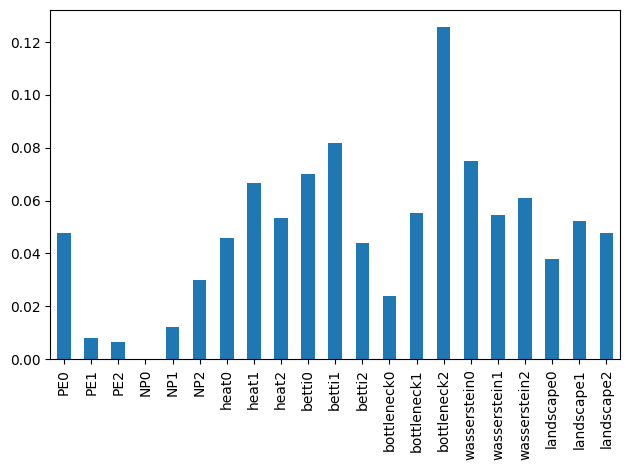

In [126]:
feature_types = ["PE", "NP", "heat", "betti", "bottleneck", "wasserstein", "landscape"]
feature_names = [type + str(i) for type in feature_types for i in homology_dimensions]
importances = p["rf"].feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
fig.tight_layout()


From here it looks like the most prominent predictors turn out to be 

1. Bottleneck distance in dimension 2, 
2. The betti amplitude in dimension 1, and
3. The Wasserstein metric in dimension 0

where the wasserstein metric behaves comparably to the betti amplitude in dimension 0 and the heat (homology contour) map in dimension 0.
